In [19]:
%matplotlib inline

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import copy
import time

from multi_rake import Rake
from sklearn import datasets, linear_model

# ls in data location
# import os
# print(os.listdir("./data"))

In [21]:
reviewsRawData = pd.read_csv("./data/Hotel_Reviews.csv", usecols=['Positive_Review', 'Negative_Review', 'Reviewer_Score'])

In [22]:
# to make sure there's no empty attribute
reviewsRawData.count()

Negative_Review    515738
Positive_Review    515738
Reviewer_Score     515738
dtype: int64

In [23]:
#since there's no empty attribute, we can seperate each column to convert reviews to numberic values
reviewsRawDataPos = reviewsRawData.Positive_Review[100000:515738, np.newaxis]
reviewsRawDataNeg = reviewsRawData.Negative_Review[100000:515738, np.newaxis]
reviewerScore = reviewsRawData.Reviewer_Score[100000:515738, np.newaxis]

In [24]:
rake = Rake()

reviewsNumData = copy.deepcopy(reviewsRawDataPos);

start_time = time.time()

for i in range(0, len(reviewsRawDataPos)):
    reviewsNumData[i][0] = 0
    # get important keywords with weight for each positive review
    posKeywords = rake.apply(reviewsRawDataPos[i][0])
    # each keyword's weight gets added up
    for eachTuple in posKeywords:
        reviewsNumData[i][0]= reviewsNumData[i][0] + eachTuple[1]/10
    
    # get important keywords with weight for each negative review
    negKeywords = rake.apply(reviewsRawDataNeg[i][0])
    # each keyword's weight gets subtracted
    for eachTuple in negKeywords:
        reviewsNumData[i][0]= reviewsNumData[i][0] - eachTuple[1]/10

    #print(reviewsNumData[i])

# con: due to size of the data, conversion takes time (~5mins)
print("Time taken for conversion: %s minutes " % ((time.time() - start_time)/60))

Time taken for conversion: 2.1801040132840472 minutes 


In [25]:
# This part was made with referencing Linear regression - OLS vs GD
# Split the data into training/testing sets
reviews_X_train = copy.deepcopy(reviewsNumData[:-84000]) # training set = all but last 84000 instances
reviews_X_test = copy.deepcopy(reviewsNumData[-84000:])  #test set = last 84000 instances
print(len(reviews_X_train))
print(len(reviews_X_test))
# Split the targets into training/testing sets
reviews_Y_train = copy.deepcopy(reviewerScore[:-84000])
reviews_Y_test = copy.deepcopy(reviewerScore[-84000:])
print(len(reviews_Y_train))
print(len(reviews_Y_test))

331738
84000
331738
84000


C:\Users\L\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coefficients: 
 [0.38051774]
Y-intercept: 
 [8.34330431]
Variance score: 0.21


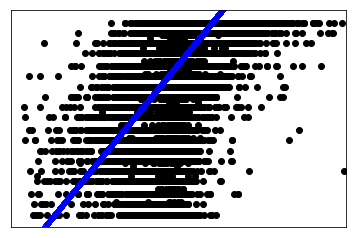

In [27]:
# This part was made with referencing Linear regression - OLS vs GD
# Create linear regression object

#regr = linear_model.LinearRegression() #run ordinary least squares

#Gradient Descent 
regr=linear_model.SGDRegressor(loss='squared_loss', alpha=0.000000001, max_iter=150) 
#regr=linear_model.SGDRegressor(loss='squared_loss', alpha=0.01, max_iter=60) #original

# Train the model using the training sets
regr.fit(reviews_X_train, reviews_Y_train) ##this is where "learning" happens!

# The coefficients
print('Coefficients: \n', regr.coef_)
print('Y-intercept: \n', regr.intercept_)
# The mean squared error
#print("Mean squared error: %.2f"
#     % np.mean((regr.predict(reviews_X_train) - reviews_Y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(reviews_X_test, reviews_Y_test))

# Plot outputs
plt.axis([-21, 21, 2, 10.5])
plt.scatter(reviews_X_test, reviews_Y_test,  color='black')
plt.plot(reviews_X_test, regr.predict(reviews_X_test), color='blue',
         linewidth=5)

plt.xticks(())
plt.yticks(())

plt.show()